# 06 transfer learning scaling up our previous model

In [16]:
import zipfile
import urllib.request
import random
import os
import pathlib
import datetime
import numpy as np
import pandas as pd

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys, make_confusion_matrix

import matplotlib.pylab as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import preprocessing

from sklearn.metrics import classification_report


In [3]:
# downloading dataset

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
filename = "101_food_classes_10_percent.zip"
file = urllib.request.urlretrieve(url, filename)

In [4]:
# unziping dataset

with zipfile.ZipFile("./data/101_food_classes_10_percent.zip") as zip_ref:
    zip_ref.extractall()

In [5]:
walk_through_dir("./data/101_food_classes_10_percent/")

There are 2 directories and 0 images in './data/101_food_classes_10_percent/'.
There are 101 directories and 0 images in './data/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in './data/101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in './data/101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in './data/101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in './data/101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in './data/101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in './data/101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in './data/101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in './data/101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in './data/101_food_classes_10_p

In [6]:
IMG_SIZE = (224, 224)

train_dir = "./data/101_food_classes_10_percent/train/"
test_dir = "./data/101_food_classes_10_percent/test/"

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode="categorical", image_size=IMG_SIZE)

test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode="categorical", image_size=IMG_SIZE,shuffle=False)


Found 7575 files belonging to 101 classes.


2023-02-19 19:37:43.532150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 25250 files belonging to 101 classes.


In [7]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True)


In [8]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                     layers.RandomRotation(0.2),
                                     layers.RandomHeight(0.2),
                                     layers.RandomWidth(0.2),
                                     layers.RandomZoom(0.2),
                                     ],name="data_augmentation")

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),
                       activation="softmax",
                       name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## base model feature extraction

In [12]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=5,
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.15 * len(test_data_all_10_percent)),
    callbacks=[checkpoint_callback])


Epoch 1/5
237/237 [==============================] - 556s 2s/step - loss: 1.8988 - accuracy: 0.5463 - val_loss: 1.8805 - val_accuracy: 0.5294
Epoch 2/5
237/237 [==============================] - 615s 3s/step - loss: 1.6179 - accuracy: 0.6045 - val_loss: 1.7664 - val_accuracy: 0.5445
Epoch 3/5
237/237 [==============================] - 605s 3s/step - loss: 1.4596 - accuracy: 0.6424 - val_loss: 1.7339 - val_accuracy: 0.5490
Epoch 4/5
237/237 [==============================] - 597s 3s/step - loss: 1.3407 - accuracy: 0.6664 - val_loss: 1.7032 - val_accuracy: 0.5577
Epoch 5/5
237/237 [==============================] - 543s 2s/step - loss: 1.2235 - accuracy: 0.6997 - val_loss: 1.6687 - val_accuracy: 0.5612


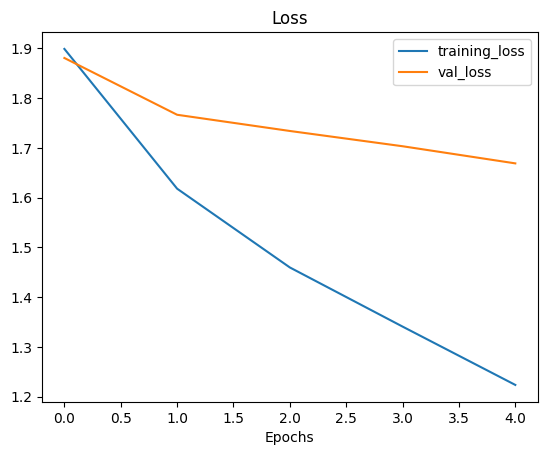

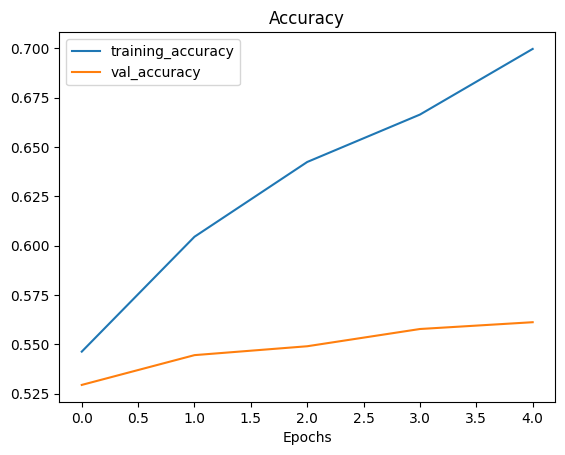

In [13]:
plot_loss_curves(history_all_classes_10_percent)

## fine tuning last 5 layers

In [14]:
base_model.trainable = True

for l in base_model.layers[:-5]:
    l.trainable = False


In [15]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [20]:
fine_tune_epochs = 10
history_all_classes_10_percent_fine_tune = model.fit(
    train_data_all_10_percent,
    epochs=fine_tune_epochs,
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.15 * len(test_data_all_10_percent)),
    initial_epoch=history_all_classes_10_percent.epoch[-1],
    callbacks=[checkpoint_callback])


Epoch 5/10
237/237 [==============================] - 511s 2s/step - loss: 0.8904 - accuracy: 0.7551 - val_loss: 1.6371 - val_accuracy: 0.5731
Epoch 6/10
237/237 [==============================] - 511s 2s/step - loss: 0.8323 - accuracy: 0.7725 - val_loss: 1.6353 - val_accuracy: 0.5802
Epoch 7/10
237/237 [==============================] - 496s 2s/step - loss: 0.7653 - accuracy: 0.7972 - val_loss: 1.6865 - val_accuracy: 0.5628
Epoch 8/10
237/237 [==============================] - 505s 2s/step - loss: 0.7121 - accuracy: 0.8078 - val_loss: 1.7394 - val_accuracy: 0.5532
Epoch 9/10
237/237 [==============================] - 501s 2s/step - loss: 0.6578 - accuracy: 0.8224 - val_loss: 1.7047 - val_accuracy: 0.5683
Epoch 10/10
237/237 [==============================] - 448s 2s/step - loss: 0.6447 - accuracy: 0.8276 - val_loss: 1.7147 - val_accuracy: 0.5662


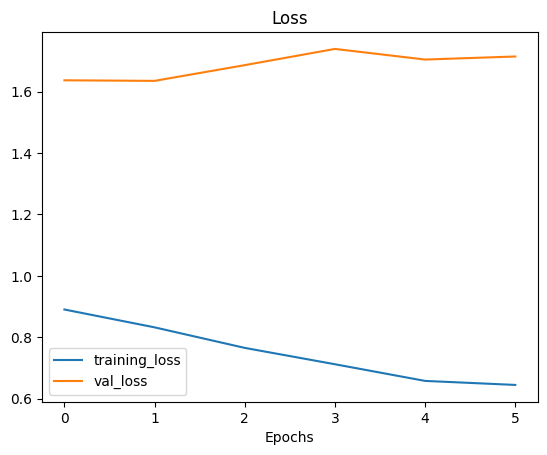

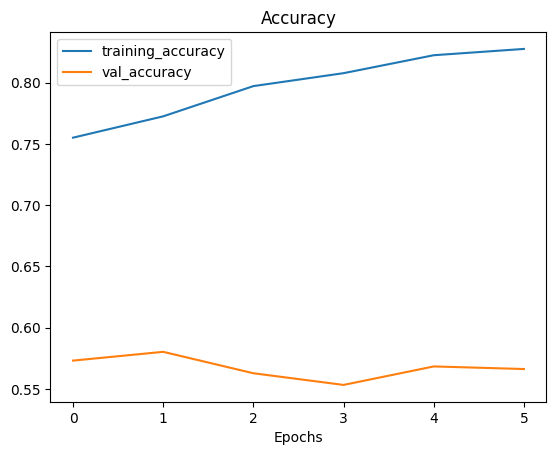

In [21]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

## saving model

In [22]:
model.save("./Saves/101_food_classes")

INFO:tensorflow:Assets written to: ./Saves/101_food_classes/assets


INFO:tensorflow:Assets written to: ./Saves/101_food_classes/assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

## making predictions

In [23]:
preds_probs = model.predict(test_data_all_10_percent,verbose=1)
len(preds_probs)

790/790 [==============================] - 1118s 1s/step


25250

In [24]:
preds_probs.shape

(25250, 101)

In [26]:
p = tf.argmax(preds_probs)
print(p)

tf.Tensor(
[  172   375   672   905  1113  1482  1562  1963  2192  2359 11642  2797
  3172  3368  3582  3793  4188  4306  4528  4870  5222  5300  5713  5778
  6196  6302  6683  6833  7192  7409  7645  7884  8021  8256  8668  8761
  9205  9318  9659  9762 10056 10401 10502 10841 11054 11292 11531 11907
 12136 12493 12517 12967 13028 13330 13649 13802 14109 14473 14746 14830
 15026 15398 15690 15907 16134 16329 16625 16758 17063 17495 17514 17930
 18235 18276 18702 18877 19050  9761 19549 19966 20017 20356  3255 20764
 21211 21275 21647 21765 22063 22442 22720 22796 23122 19323 23588 23828
 24103 24293 24723 24961 25095], shape=(101,), dtype=int64)


In [27]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29,  0,  9,  0])

In [28]:
y_labels = []
for images,labels in test_data_all_10_percent.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## making confusion matrix

In [ ]:
# tbh dont worry about this... hes buildign a confusion matrix of 101 classes. mans crazy :D

# class_names = test_data_all_10_percent.class_names
# make_confusion_matrix(y_true=y_labels,y_pred=pred_classes,classes=class_names,figsize=(100,100),text_size=20,)

## classification report

In [29]:
print(classification_report(y_true=y_labels,y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.30      0.28      0.29       250
           1       0.56      0.74      0.64       250
           2       0.65      0.61      0.63       250
           3       0.83      0.54      0.65       250
           4       0.57      0.32      0.41       250
           5       0.50      0.42      0.46       250
           6       0.73      0.81      0.77       250
           7       0.79      0.82      0.81       250
           8       0.29      0.56      0.39       250
           9       0.36      0.75      0.48       250
          10       0.54      0.46      0.50       250
          11       0.86      0.54      0.66       250
          12       0.67      0.60      0.63       250
          13       0.66      0.50      0.56       250
          14       0.59      0.57      0.58       250
          15       0.40      0.38      0.39       250
          16       0.68      0.52      0.59       250
          17       0.42    

## finding the most wrong data

In [30]:
filepaths = []
for fp in test_data_all_10_percent.list_files("./data/101_food_classes_10_percent/test/*/*.jpg",shuffle=False):
    filepaths.append(fp.numpy())

filepaths[:10]

[b'./data/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1113017.jpg']